In [1]:
import os
import sys
import torch
import wandb
# import GPUtil
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from ESTFormer import ESTFormer

sys.path.append('../../')
from utils.epoch_data_reader import EpochDataReader

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # Force CUDA to use the GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use first GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # Enable memory optimization settings for PyTorch
os.environ['WANDB_NOTEBOOK_NAME'] = 'model_training'

In [17]:
# # Check if CUDA is available
# try:
#     gpus = GPUtil.getGPUs()
#     if gpus:
#         print(f"GPUtil detected {len(gpus)} GPUs:")
#         for i, gpu in enumerate(gpus):
#             print(f"  GPU {i}: {gpu.name} (Memory: {gpu.memoryTotal}MB)")
        
#         # Set default GPU
#         os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in range(len(gpus))])
#         print(f"Set CUDA_VISIBLE_DEVICES={os.environ['CUDA_VISIBLE_DEVICES']}")
#     else:
#         print("GPUtil found no available GPUs")
# except Exception as e:
#     print(f"Error checking GPUs with GPUtil: {e}")

In [3]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Print available GPU memory
if torch.cuda.is_available():
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

Using device: cuda
Total GPU memory: 99.98 GB
Available GPU memory: 0.00 GB


In [4]:
all_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

hr_channel_names = [
    'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 
    'Iz', 'Oz', 'POz', 'Pz', 'CPz', 
    'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2'
]

# Select 32 channels for the downsampled (low-resolution) set
# This selection preserves the overall spatial coverage while reducing density
lr_channel_names = [
    'CP3', 'P3', 'P7', 'PO7', 'O1',
    'CPz', 'Pz', 'POz', 'Oz',
    'CP4', 'P4', 'P8', 'PO8', 'O2'
]

# Model parameters
# hr_channel_names = all_channels # High-resolution setup (all channels)
# lr_channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] # Low-resolution setup (fewer channels)
builtin_montage = 'standard_1020'
alpha_t = 0.60
alpha_s = 0.75
r_mlp = 4 # amplification factor for MLP layers
dropout_rate = 0.5
L_s = 1  # Number of spatial layers
L_t = 1  # Number of temporal layers

# Training parameters
epochs = 100

# Optimizer parameters
lr = 5e-5
weight_decay = 0.5
beta_1 = 0.9
beta_2 = 0.95

# Dataset parameters
# split = "70/25/5"
# epoch_type = "around_evoked"
# before = 0.05
# after = 0.6
# random_state = 97

# Data Loader parameter
batch_size = 64

In [5]:
# Create datasets
lo_res_dataset = EpochDataReader(
    channel_names=lr_channel_names
)

hi_res_dataset = EpochDataReader(
    channel_names=hr_channel_names
)

Creating new group: cross/ground-truth/CP3-CP4-CPz-O1-O2-Oz-P3-P4-P7-P8-PO7-PO8-POz-Pz/512/around_evoked/0.65/70_25_5/97
Opening raw data file /workspace/eeg-image-decoding/code/utils/../../data/all-joined-1/eeg/preprocessed/ground-truth/subj01_session1_eeg.fif...
    Range : 1121 ... 1777926 =      2.189 ...  3472.512 secs
Ready.
Opening raw data file /workspace/eeg-image-decoding/code/utils/../../data/all-joined-1/eeg/preprocessed/ground-truth/subj01_session1_eeg.fif...
    Range : 1121 ... 1777926 =      2.189 ...  3472.512 secs
Ready.
3839 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 1

In [6]:
lo_res_loader = DataLoader(
    lo_res_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

hi_res_loader = DataLoader(
    hi_res_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

len(lo_res_loader), len(hi_res_loader)

(719, 719)

In [7]:
lo_res_dataset[0][0].shape, hi_res_dataset[0][0].shape

((14, 338), (29, 338))

In [10]:
# Get sample data to determine time_steps
sample_item = lo_res_dataset[0][0] if lo_res_dataset.epoch_type == 'around_evoked' else lo_res_dataset[0]
time_steps = sample_item.shape[1]
sfreq = lo_res_dataset.resample_freq

config = {
    "total_epochs_trained_on": epochs,
    "scale_factor": len(hr_channel_names) / len(lr_channel_names),
    "time_steps_in_seconds": time_steps / sfreq,
    "is_parieto_occipital_exclusive": True,#all(ch.startswith('P') or ch.startswith('O') or ch.startswith('PO') or ch.startswith('CP') for ch in lr_channel_names) and all(ch.startswith('P') or ch.startswith('O') or ch.startswith('PO') or ch.startswith('CP') for ch in hr_channel_names),
    "model_params": {
        "model": "ESTformer",
        "num_lr_channels": len(lr_channel_names),
        "num_hr_channels": len(hr_channel_names),
        "builtin_montage": builtin_montage,
        "alpha_s": alpha_s,
        "alpha_t": alpha_t,
        "r_mlp": r_mlp,
        "dropout_rate": dropout_rate,
        "L_s": L_s,
        "L_t": L_t,
    },
    "dataset_params": {
        "subject_session_id": lo_res_dataset.subject_session_id,
        "epoch_type": lo_res_dataset.epoch_type,
        "split": lo_res_dataset.split,
        "duration": str((lo_res_dataset.before + lo_res_dataset.after) * 1000) + 'ms' if lo_res_dataset.epoch_type == 'around_evoked' else lo_res_dataset.fixed_length_duration,
        "batch_size": batch_size,
        "random_state": lo_res_dataset.random_state
    },
    "optimizer_params": {
        "optimizer": "Adam",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "betas": (beta_1, beta_2)
    }
}

In [9]:
model = ESTFormer(
    device=device, 
    lr_channel_names=lr_channel_names,
    hr_channel_names=hr_channel_names,
    builtin_montage=builtin_montage,
    time_steps=time_steps,
    alpha_t=alpha_t,
    alpha_s=alpha_s,
    r_mlp=r_mlp,
    dropout_rate=dropout_rate,
    L_s=L_s,
    L_t=L_t
)

summary(model)

Layer (type:depth-idx)                                                                Param #
ESTFormer                                                                             204
├─SigmaParameters: 1-1                                                                2
├─SIM: 1-2                                                                            --
│    └─Linear: 2-1                                                                    69,156
│    └─LayerNorm: 2-2                                                                 408
│    └─CAB: 2-3                                                                       --
│    │    └─ModuleList: 3-1                                                           507,112
│    └─MaskTokensInsert: 2-4                                                          --
│    │    └─MaskTokenExpander: 3-2                                                    204
│    └─Linear: 2-5                                                                    41,820
│

In [11]:
# Create optimizer with both model and sigma parameters
optimizer = optim.Adam(
    params=[{'params': model.parameters()}], 
    lr=lr,
    weight_decay=weight_decay,
    betas=(beta_1, beta_2)
)

with wandb.init(project="eeg-estformer", config=config) as run:
    history = model.fit(
        epochs=100,
        lo_res_loader=lo_res_loader,
        hi_res_loader=hi_res_loader,
        optimizer=optimizer,
        checkpoint_dir='cpoints',
        identifier='cross_PO_650ms_29_14',
        # use_checkpoint=False
    )


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find model_training.
wandb: Currently logged in as: dubs2310 (dubs2310-cal-poly-pomona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/100: 100%|██████████| 503/503 [00:13<00:00, 36.47it/s, loss=253.6526]
                                                                                     

Epoch 1/100, train_loss: 316.7677val_loss: 280.9430sigma1: 1.0245, sigma2: 0.9749
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 2/100: 100%|██████████| 503/503 [00:14<00:00, 35.01it/s, loss=261.9859]
                                                                                     

Epoch 2/100, train_loss: 273.4967val_loss: 255.3022sigma1: 1.0489, sigma2: 0.9498
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 3/100: 100%|██████████| 503/503 [00:13<00:00, 37.73it/s, loss=217.2534]
                                                                                     

Epoch 3/100, train_loss: 250.0037val_loss: 235.0842sigma1: 1.0734, sigma2: 0.9248
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 4/100: 100%|██████████| 503/503 [00:13<00:00, 38.13it/s, loss=226.3648]
                                                                                     

Epoch 4/100, train_loss: 231.7533val_loss: 219.0827sigma1: 1.0978, sigma2: 0.8998
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 5/100: 100%|██████████| 503/503 [00:14<00:00, 34.30it/s, loss=263.3560]
                                                                                     

Epoch 5/100, train_loss: 216.6852val_loss: 205.3313sigma1: 1.1221, sigma2: 0.8749
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 6/100: 100%|██████████| 503/503 [00:14<00:00, 34.09it/s, loss=184.8369]
                                                                                     

Epoch 6/100, train_loss: 203.4033val_loss: 192.4951sigma1: 1.1465, sigma2: 0.8502
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 7/100: 100%|██████████| 503/503 [00:13<00:00, 36.89it/s, loss=151.6013]
                                                                                     

Epoch 7/100, train_loss: 191.1844val_loss: 180.8750sigma1: 1.1708, sigma2: 0.8259
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 8/100: 100%|██████████| 503/503 [00:13<00:00, 35.95it/s, loss=188.2256]
                                                                                     

Epoch 8/100, train_loss: 179.9582val_loss: 170.3329sigma1: 1.1951, sigma2: 0.8031
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 9/100: 100%|██████████| 503/503 [00:13<00:00, 35.98it/s, loss=144.5032]
                                                                                     

Epoch 9/100, train_loss: 169.6141val_loss: 160.4126sigma1: 1.2194, sigma2: 0.7859
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 10/100: 100%|██████████| 503/503 [00:13<00:00, 37.99it/s, loss=130.3663]
                                                                                     

Epoch 10/100, train_loss: 159.9540val_loss: 151.3602sigma1: 1.2437, sigma2: 0.7785
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 11/100: 100%|██████████| 503/503 [00:13<00:00, 38.13it/s, loss=134.4839]
                                                                                     

Epoch 11/100, train_loss: 150.9934val_loss: 142.8985sigma1: 1.2682, sigma2: 0.7735
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 12/100: 100%|██████████| 503/503 [00:13<00:00, 37.78it/s, loss=174.9332]
                                                                                     

Epoch 12/100, train_loss: 142.8959val_loss: 135.2720sigma1: 1.2922, sigma2: 0.7679
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 13/100: 100%|██████████| 503/503 [00:13<00:00, 38.34it/s, loss=118.8633]
                                                                                     

Epoch 13/100, train_loss: 135.2608val_loss: 127.9801sigma1: 1.3164, sigma2: 0.7629
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 14/100: 100%|██████████| 503/503 [00:14<00:00, 35.09it/s, loss=104.9663]
                                                                                     

Epoch 14/100, train_loss: 128.1269val_loss: 121.2925sigma1: 1.3406, sigma2: 0.7591
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 15/100: 100%|██████████| 503/503 [00:14<00:00, 34.59it/s, loss=109.6677]
                                                                                     

Epoch 15/100, train_loss: 121.6386val_loss: 115.1916sigma1: 1.3647, sigma2: 0.7542
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 16/100: 100%|██████████| 503/503 [00:14<00:00, 34.29it/s, loss=117.1685]
                                                                                     

Epoch 16/100, train_loss: 115.5716val_loss: 109.4877sigma1: 1.3887, sigma2: 0.7497
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 17/100: 100%|██████████| 503/503 [00:13<00:00, 36.68it/s, loss=97.8148] 
                                                                                     

Epoch 17/100, train_loss: 109.9001val_loss: 104.2701sigma1: 1.4129, sigma2: 0.7453
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 18/100: 100%|██████████| 503/503 [00:14<00:00, 33.79it/s, loss=105.0171]
                                                                                     

Epoch 18/100, train_loss: 104.7777val_loss: 99.2833sigma1: 1.4368, sigma2: 0.7404
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 19/100: 100%|██████████| 503/503 [00:13<00:00, 38.42it/s, loss=101.4676]
                                                                                     

Epoch 19/100, train_loss: 99.9827val_loss: 94.7680sigma1: 1.4608, sigma2: 0.7359
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 20/100: 100%|██████████| 503/503 [00:13<00:00, 36.23it/s, loss=75.6769] 
                                                                                     

Epoch 20/100, train_loss: 95.4734val_loss: 90.5590sigma1: 1.4847, sigma2: 0.7324
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 21/100: 100%|██████████| 503/503 [00:14<00:00, 34.44it/s, loss=106.0263]
                                                                                     

Epoch 21/100, train_loss: 91.3360val_loss: 86.7537sigma1: 1.5086, sigma2: 0.7279
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 22/100: 100%|██████████| 503/503 [00:13<00:00, 37.99it/s, loss=198.3763]
                                                                                     

Epoch 22/100, train_loss: 87.4989val_loss: 83.0723sigma1: 1.5325, sigma2: 0.7237
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 23/100: 100%|██████████| 503/503 [00:14<00:00, 35.00it/s, loss=87.0625] 
                                                                                     

Epoch 23/100, train_loss: 83.9262val_loss: 79.8180sigma1: 1.5564, sigma2: 0.7201
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 24/100: 100%|██████████| 503/503 [00:13<00:00, 38.24it/s, loss=69.1165] 
                                                                                     

Epoch 24/100, train_loss: 80.6143val_loss: 76.6380sigma1: 1.5802, sigma2: 0.7170
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 25/100: 100%|██████████| 503/503 [00:13<00:00, 37.19it/s, loss=79.3638] 
                                                                                     

Epoch 25/100, train_loss: 77.5799val_loss: 73.7560sigma1: 1.6039, sigma2: 0.7138
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 26/100: 100%|██████████| 503/503 [00:12<00:00, 40.02it/s, loss=70.4957] 
                                                                                     

Epoch 26/100, train_loss: 74.7076val_loss: 71.0679sigma1: 1.6279, sigma2: 0.7104
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 27/100: 100%|██████████| 503/503 [00:13<00:00, 37.60it/s, loss=71.7140] 
                                                                                     

Epoch 27/100, train_loss: 72.0997val_loss: 68.6564sigma1: 1.6515, sigma2: 0.7073
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 28/100: 100%|██████████| 503/503 [00:14<00:00, 35.59it/s, loss=55.7858] 
                                                                                     

Epoch 28/100, train_loss: 69.6985val_loss: 66.3958sigma1: 1.6752, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 29/100: 100%|██████████| 503/503 [00:13<00:00, 35.98it/s, loss=74.7638] 
                                                                                     

Epoch 29/100, train_loss: 67.4602val_loss: 64.3063sigma1: 1.6989, sigma2: 0.7033
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 30/100: 100%|██████████| 503/503 [00:15<00:00, 33.43it/s, loss=47.6796] 
                                                                                     

Epoch 30/100, train_loss: 65.4183val_loss: 62.4214sigma1: 1.7228, sigma2: 0.7015
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 31/100: 100%|██████████| 503/503 [00:15<00:00, 32.88it/s, loss=61.0801]
                                                                                     

Epoch 31/100, train_loss: 63.5075val_loss: 60.6472sigma1: 1.7469, sigma2: 0.7007
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 32/100: 100%|██████████| 503/503 [00:14<00:00, 33.73it/s, loss=57.2168] 
                                                                                     

Epoch 32/100, train_loss: 61.8217val_loss: 59.1496sigma1: 1.7704, sigma2: 0.6998
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 33/100: 100%|██████████| 503/503 [00:15<00:00, 33.23it/s, loss=82.7976]
                                                                                     

Epoch 33/100, train_loss: 60.2527val_loss: 57.6768sigma1: 1.7941, sigma2: 0.6993
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 34/100: 100%|██████████| 503/503 [00:15<00:00, 33.12it/s, loss=59.9402]
                                                                                     

Epoch 34/100, train_loss: 58.8552val_loss: 56.3808sigma1: 1.8179, sigma2: 0.6988
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 35/100: 100%|██████████| 503/503 [00:15<00:00, 32.30it/s, loss=63.5215] 
                                                                                     

Epoch 35/100, train_loss: 57.5938val_loss: 55.2434sigma1: 1.8416, sigma2: 0.6986
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 36/100: 100%|██████████| 503/503 [00:14<00:00, 33.88it/s, loss=55.3255]
                                                                                     

Epoch 36/100, train_loss: 56.4372val_loss: 54.2144sigma1: 1.8655, sigma2: 0.6999
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 37/100: 100%|██████████| 503/503 [00:15<00:00, 32.73it/s, loss=53.8587] 
                                                                                     

Epoch 37/100, train_loss: 55.4405val_loss: 53.3324sigma1: 1.8891, sigma2: 0.7006
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 38/100: 100%|██████████| 503/503 [00:14<00:00, 33.69it/s, loss=57.3038] 
                                                                                     

Epoch 38/100, train_loss: 54.5349val_loss: 52.5696sigma1: 1.9129, sigma2: 0.7023
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 39/100: 100%|██████████| 503/503 [00:15<00:00, 33.17it/s, loss=55.0328]
                                                                                     

Epoch 39/100, train_loss: 53.7675val_loss: 51.8133sigma1: 1.9367, sigma2: 0.7040
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 40/100: 100%|██████████| 503/503 [00:15<00:00, 32.90it/s, loss=50.0326]
                                                                                     

Epoch 40/100, train_loss: 52.8916val_loss: 50.8111sigma1: 1.9605, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 41/100: 100%|██████████| 503/503 [00:15<00:00, 32.88it/s, loss=52.3677]
                                                                                     

Epoch 41/100, train_loss: 51.6039val_loss: 49.5180sigma1: 1.9844, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 42/100: 100%|██████████| 503/503 [00:15<00:00, 32.96it/s, loss=54.4089] 
                                                                                     

Epoch 42/100, train_loss: 50.3494val_loss: 48.2582sigma1: 2.0082, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 43/100: 100%|██████████| 503/503 [00:15<00:00, 33.01it/s, loss=41.3404]
                                                                                     

Epoch 43/100, train_loss: 49.1211val_loss: 47.1586sigma1: 2.0323, sigma2: 0.7046
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 44/100: 100%|██████████| 503/503 [00:15<00:00, 33.17it/s, loss=41.6864]
                                                                                     

Epoch 44/100, train_loss: 48.0261val_loss: 46.1041sigma1: 2.0558, sigma2: 0.7043
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 45/100: 100%|██████████| 503/503 [00:15<00:00, 33.21it/s, loss=53.9679]
                                                                                     

Epoch 45/100, train_loss: 46.9706val_loss: 45.1169sigma1: 2.0796, sigma2: 0.7043
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 46/100: 100%|██████████| 503/503 [00:15<00:00, 32.68it/s, loss=47.8975] 
                                                                                     

Epoch 46/100, train_loss: 45.9651val_loss: 44.1585sigma1: 2.1034, sigma2: 0.7046
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 47/100: 100%|██████████| 503/503 [00:15<00:00, 33.20it/s, loss=43.1466]
                                                                                     

Epoch 47/100, train_loss: 44.9851val_loss: 43.2259sigma1: 2.1272, sigma2: 0.7042
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 48/100: 100%|██████████| 503/503 [00:15<00:00, 33.39it/s, loss=39.9660]
                                                                                     

Epoch 48/100, train_loss: 44.0257val_loss: 42.3295sigma1: 2.1510, sigma2: 0.7043
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 49/100: 100%|██████████| 503/503 [00:14<00:00, 34.30it/s, loss=31.2110] 
                                                                                     

Epoch 49/100, train_loss: 43.1076val_loss: 41.4169sigma1: 2.1747, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 50/100: 100%|██████████| 503/503 [00:14<00:00, 34.40it/s, loss=35.6543]
                                                                                     

Epoch 50/100, train_loss: 42.2346val_loss: 40.6121sigma1: 2.1984, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 51/100: 100%|██████████| 503/503 [00:14<00:00, 35.71it/s, loss=37.2503]
                                                                                     

Epoch 51/100, train_loss: 41.3661val_loss: 39.8053sigma1: 2.2223, sigma2: 0.7046
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 52/100: 100%|██████████| 503/503 [00:13<00:00, 37.15it/s, loss=52.5683] 
                                                                                     

Epoch 52/100, train_loss: 40.5402val_loss: 38.9939sigma1: 2.2460, sigma2: 0.7045
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 53/100: 100%|██████████| 503/503 [00:14<00:00, 34.27it/s, loss=36.7341] 
                                                                                     

Epoch 53/100, train_loss: 39.7287val_loss: 38.1911sigma1: 2.2700, sigma2: 0.7044
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 54/100: 100%|██████████| 503/503 [00:14<00:00, 34.53it/s, loss=39.3284]
                                                                                     

Epoch 54/100, train_loss: 38.9497val_loss: 37.4698sigma1: 2.2936, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 55/100: 100%|██████████| 503/503 [00:14<00:00, 34.92it/s, loss=30.2446] 
                                                                                     

Epoch 55/100, train_loss: 38.1906val_loss: 36.7562sigma1: 2.3174, sigma2: 0.7047
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 56/100: 100%|██████████| 503/503 [00:14<00:00, 34.93it/s, loss=32.9092]
                                                                                     

Epoch 56/100, train_loss: 37.4430val_loss: 36.0916sigma1: 2.3413, sigma2: 0.7052
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 57/100: 100%|██████████| 503/503 [00:14<00:00, 35.55it/s, loss=74.8284] 
                                                                                     

Epoch 57/100, train_loss: 36.7338val_loss: 35.3766sigma1: 2.3651, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 58/100: 100%|██████████| 503/503 [00:14<00:00, 35.05it/s, loss=33.3138] 
                                                                                     

Epoch 58/100, train_loss: 36.0502val_loss: 34.6986sigma1: 2.3889, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 59/100: 100%|██████████| 503/503 [00:14<00:00, 35.35it/s, loss=33.4184]
                                                                                     

Epoch 59/100, train_loss: 35.3794val_loss: 34.1027sigma1: 2.4126, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 60/100: 100%|██████████| 503/503 [00:15<00:00, 33.28it/s, loss=32.3360]
                                                                                     

Epoch 60/100, train_loss: 34.7607val_loss: 33.4335sigma1: 2.4361, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 61/100: 100%|██████████| 503/503 [00:15<00:00, 31.48it/s, loss=43.3167]
                                                                                     

Epoch 61/100, train_loss: 34.1024val_loss: 32.8606sigma1: 2.4599, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 62/100: 100%|██████████| 503/503 [00:16<00:00, 30.38it/s, loss=27.4377]
                                                                                     

Epoch 62/100, train_loss: 33.4953val_loss: 32.2608sigma1: 2.4838, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 63/100: 100%|██████████| 503/503 [00:17<00:00, 28.32it/s, loss=30.1798]
                                                                                     

Epoch 63/100, train_loss: 32.9053val_loss: 31.6775sigma1: 2.5072, sigma2: 0.7054
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 64/100: 100%|██████████| 503/503 [00:15<00:00, 32.73it/s, loss=37.0656]
                                                                                     

Epoch 64/100, train_loss: 32.3312val_loss: 31.1313sigma1: 2.5309, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 65/100: 100%|██████████| 503/503 [00:15<00:00, 32.03it/s, loss=76.4589]
                                                                                     

Epoch 65/100, train_loss: 31.7675val_loss: 30.5938sigma1: 2.5547, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 66/100: 100%|██████████| 503/503 [00:15<00:00, 32.55it/s, loss=29.4128]
                                                                                     

Epoch 66/100, train_loss: 31.2125val_loss: 30.1023sigma1: 2.5782, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 67/100: 100%|██████████| 503/503 [00:15<00:00, 31.62it/s, loss=27.7303]
                                                                                     

Epoch 67/100, train_loss: 30.6895val_loss: 29.5855sigma1: 2.6020, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 68/100: 100%|██████████| 503/503 [00:16<00:00, 31.22it/s, loss=25.6520]
                                                                                     

Epoch 68/100, train_loss: 30.1846val_loss: 29.0741sigma1: 2.6259, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 69/100: 100%|██████████| 503/503 [00:16<00:00, 30.19it/s, loss=28.1149] 
                                                                                     

Epoch 69/100, train_loss: 29.6617val_loss: 28.5891sigma1: 2.6497, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 70/100: 100%|██████████| 503/503 [00:16<00:00, 30.77it/s, loss=26.4562]
                                                                                     

Epoch 70/100, train_loss: 29.1702val_loss: 28.1485sigma1: 2.6735, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 71/100: 100%|██████████| 503/503 [00:16<00:00, 30.57it/s, loss=23.3600]
                                                                                     

Epoch 71/100, train_loss: 28.6969val_loss: 27.6629sigma1: 2.6973, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 72/100: 100%|██████████| 503/503 [00:14<00:00, 34.13it/s, loss=19.9001]
                                                                                     

Epoch 72/100, train_loss: 28.2308val_loss: 27.2081sigma1: 2.7208, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 73/100: 100%|██████████| 503/503 [00:15<00:00, 32.99it/s, loss=24.8617]
                                                                                     

Epoch 73/100, train_loss: 27.7772val_loss: 26.7940sigma1: 2.7443, sigma2: 0.7054
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 74/100: 100%|██████████| 503/503 [00:15<00:00, 33.47it/s, loss=24.3390] 
                                                                                     

Epoch 74/100, train_loss: 27.3360val_loss: 26.3785sigma1: 2.7680, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 75/100: 100%|██████████| 503/503 [00:15<00:00, 33.51it/s, loss=22.5679] 
                                                                                     

Epoch 75/100, train_loss: 26.9145val_loss: 25.9550sigma1: 2.7917, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 76/100: 100%|██████████| 503/503 [00:15<00:00, 32.92it/s, loss=27.5143]
                                                                                     

Epoch 76/100, train_loss: 26.4962val_loss: 25.5683sigma1: 2.8152, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 77/100: 100%|██████████| 503/503 [00:14<00:00, 34.01it/s, loss=21.7992]
                                                                                     

Epoch 77/100, train_loss: 26.0854val_loss: 25.1806sigma1: 2.8389, sigma2: 0.7060
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 78/100: 100%|██████████| 503/503 [00:15<00:00, 32.19it/s, loss=25.1529]
                                                                                     

Epoch 78/100, train_loss: 25.6998val_loss: 24.7849sigma1: 2.8625, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 79/100: 100%|██████████| 503/503 [00:15<00:00, 33.37it/s, loss=24.8610]
                                                                                     

Epoch 79/100, train_loss: 25.3020val_loss: 24.4096sigma1: 2.8862, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 80/100: 100%|██████████| 503/503 [00:14<00:00, 33.86it/s, loss=20.8683]
                                                                                     

Epoch 80/100, train_loss: 24.9295val_loss: 24.0481sigma1: 2.9098, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 81/100: 100%|██████████| 503/503 [00:14<00:00, 34.70it/s, loss=18.4947]
                                                                                     

Epoch 81/100, train_loss: 24.5619val_loss: 23.7129sigma1: 2.9332, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 82/100: 100%|██████████| 503/503 [00:14<00:00, 34.81it/s, loss=26.8024]
                                                                                     

Epoch 82/100, train_loss: 24.2077val_loss: 23.3693sigma1: 2.9568, sigma2: 0.7058
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 83/100: 100%|██████████| 503/503 [00:14<00:00, 34.98it/s, loss=18.1799]
                                                                                     

Epoch 83/100, train_loss: 23.8545val_loss: 23.0350sigma1: 2.9804, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 84/100: 100%|██████████| 503/503 [00:15<00:00, 33.03it/s, loss=18.1737]
                                                                                     

Epoch 84/100, train_loss: 23.5098val_loss: 22.7209sigma1: 3.0041, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 85/100: 100%|██████████| 503/503 [00:15<00:00, 32.92it/s, loss=24.4679]
                                                                                     

Epoch 85/100, train_loss: 23.1723val_loss: 22.3795sigma1: 3.0277, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 86/100: 100%|██████████| 503/503 [00:15<00:00, 33.03it/s, loss=22.3791]
                                                                                     

Epoch 86/100, train_loss: 22.8509val_loss: 22.0622sigma1: 3.0513, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 87/100: 100%|██████████| 503/503 [00:15<00:00, 32.43it/s, loss=29.3055]
                                                                                     

Epoch 87/100, train_loss: 22.5350val_loss: 21.7689sigma1: 3.0749, sigma2: 0.7058
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 88/100: 100%|██████████| 503/503 [00:15<00:00, 33.27it/s, loss=20.7607]
                                                                                     

Epoch 88/100, train_loss: 22.2179val_loss: 21.4752sigma1: 3.0986, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 89/100: 100%|██████████| 503/503 [00:15<00:00, 32.71it/s, loss=23.7355]
                                                                                     

Epoch 89/100, train_loss: 21.9175val_loss: 21.1709sigma1: 3.1219, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 90/100: 100%|██████████| 503/503 [00:15<00:00, 32.78it/s, loss=20.1229]
                                                                                     

Epoch 90/100, train_loss: 21.6246val_loss: 20.8897sigma1: 3.1454, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 91/100: 100%|██████████| 503/503 [00:15<00:00, 33.38it/s, loss=25.4850]
                                                                                     

Epoch 91/100, train_loss: 21.3315val_loss: 20.5953sigma1: 3.1693, sigma2: 0.7062
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 92/100: 100%|██████████| 503/503 [00:15<00:00, 32.46it/s, loss=17.5241]
                                                                                     

Epoch 92/100, train_loss: 21.0424val_loss: 20.3290sigma1: 3.1927, sigma2: 0.7064
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 93/100: 100%|██████████| 503/503 [00:14<00:00, 33.97it/s, loss=17.2166]
                                                                                     

Epoch 93/100, train_loss: 20.7745val_loss: 20.0639sigma1: 3.2159, sigma2: 0.7065
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 94/100: 100%|██████████| 503/503 [00:15<00:00, 32.65it/s, loss=18.2548]
                                                                                     

Epoch 94/100, train_loss: 20.4976val_loss: 19.8347sigma1: 3.2395, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 95/100: 100%|██████████| 503/503 [00:15<00:00, 32.80it/s, loss=16.6193]
                                                                                     

Epoch 95/100, train_loss: 20.2365val_loss: 19.5625sigma1: 3.2631, sigma2: 0.7067
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 96/100: 100%|██████████| 503/503 [00:15<00:00, 32.51it/s, loss=17.5700]
                                                                                     

Epoch 96/100, train_loss: 19.9764val_loss: 19.3099sigma1: 3.2862, sigma2: 0.7068
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 97/100: 100%|██████████| 503/503 [00:15<00:00, 33.26it/s, loss=17.1692]
                                                                                     

Epoch 97/100, train_loss: 19.7268val_loss: 19.1083sigma1: 3.3096, sigma2: 0.7064
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 98/100: 100%|██████████| 503/503 [00:15<00:00, 33.33it/s, loss=17.7367]
                                                                                     

Epoch 98/100, train_loss: 19.4755val_loss: 18.8325sigma1: 3.3331, sigma2: 0.7065
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 99/100: 100%|██████████| 503/503 [00:15<00:00, 32.64it/s, loss=16.6739]
                                                                                     

Epoch 99/100, train_loss: 19.2351val_loss: 18.6046sigma1: 3.3564, sigma2: 0.7065
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


Epoch 100/100: 100%|██████████| 503/503 [00:15<00:00, 33.23it/s, loss=16.3733]
                                                                                     

Epoch 100/100, train_loss: 18.9992val_loss: 18.3855sigma1: 3.3800, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_14_best.pt


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
sigma1,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
sigma2,█▆▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▆▅▅▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
sigma1,3.38001
sigma2,0.70605
train_loss,18.99923
val_loss,18.38552


In [12]:
lo_res_loader.dataset.set_split_type("all")
hi_res_loader.dataset.set_split_type("all")
len(lo_res_loader), len(hi_res_loader)

(326, 326)

In [13]:
from utils.metrics import (
    mae as compute_mean_absolute_error, 
    nmse as compute_normalized_mean_squared_error, 
    pcc as compute_pearson_correlation_coefficient,
    snr as compute_signal_to_noise_ratio,
    loss as reconstruction_loss,
)
import numpy as np

In [15]:
test_losses = []
test_maes = []
test_nmse = []
test_snr = []
test_pcc = []
for i in range(len(lo_res_loader.dataset)):
    outputs = model.predict(torch.from_numpy(lo_res_loader.dataset[i]).float().to(model.device))
    hi_res = torch.from_numpy(hi_res_loader.dataset[i]).float().to(model.device)
    loss = reconstruction_loss(hi_res, outputs, model.sigmas.sigma1, model.sigmas.sigma2)
    mae = compute_mean_absolute_error(hi_res, outputs)
    nmse = compute_normalized_mean_squared_error(hi_res, outputs)
    snr = compute_signal_to_noise_ratio(hi_res, outputs)
    pcc = compute_pearson_correlation_coefficient(hi_res, outputs)

    test_losses.append(loss.item())
    test_maes.append(mae.item())
    test_nmse.append(nmse.item())
    test_snr.append(snr.item())
    test_pcc.append(pcc.item())

avg_test_loss = np.mean(test_losses)
avg_test_mae = np.mean(test_maes)
avg_test_nmse = np.mean(test_nmse)
avg_test_snr = np.mean(test_snr)
avg_test_pcc = np.mean(test_pcc)

print({
    'loss': avg_test_loss, 
    'mae': avg_test_mae, 
    'nmse': avg_test_nmse, 
    'snr': avg_test_snr, 
    'pcc': avg_test_pcc
})  

{'loss': np.float64(143.88838450307088), 'mae': np.float64(0.5757759003275278), 'nmse': np.float64(0.9999995535678241), 'snr': np.float64(1.8755062460520498e-06), 'pcc': np.float64(0.00035203110625150265)}


In [56]:
lo_res_sub_dataset = EpochDataReader(
    channel_names=lr_channel_names,
    epoch_type = "fixed_length",
    fixed_length_duration=2,
    subject_session_id="subj08_session1"
)

hi_res_sub_dataset = EpochDataReader(
    channel_names=hr_channel_names,
    epoch_type = "fixed_length",
    fixed_length_duration=2,
    subject_session_id="subj08_session1"
)

Opening raw data file /workspace/eeg-image-decoding/code/utils/../../data/all-joined-1/eeg/preprocessed/ground-truth/subj08_session1_eeg.fif...
    Range : 964 ... 1778950 =      1.883 ...  3474.512 secs
Ready.
Not setting metadata
1736 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1736 events and 1024 original time points ...
0 bad epochs dropped
Opening raw data file /workspace/eeg-image-decoding/code/utils/../../data/all-joined-1/eeg/preprocessed/ground-truth/subj08_session1_eeg.fif...
    Range : 964 ... 1778950 =      1.883 ...  3474.512 secs
Ready.
Not setting metadata
1736 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1736 events and 1024 original time points ...
0 bad epochs dropped


In [57]:
test_losses = []
test_maes = []
test_nmse = []
test_snr = []
test_pcc = []
for i in range(len(lo_res_sub_dataset)):
    outputs = model.predict(torch.from_numpy(lo_res_sub_dataset[i]).float().to(model.device))
    hi_res = torch.from_numpy(hi_res_sub_dataset[i]).float().to(model.device)
    loss = reconstruction_loss(hi_res, outputs, model.sigmas.sigma1, model.sigmas.sigma2)
    mae = compute_mean_absolute_error(hi_res, outputs)
    nmse = compute_normalized_mean_squared_error(hi_res, outputs)
    snr = compute_signal_to_noise_ratio(hi_res, outputs)
    pcc = compute_pearson_correlation_coefficient(hi_res, outputs)

    test_losses.append(loss.item())
    test_maes.append(mae.item())
    test_nmse.append(nmse.item())
    test_snr.append(snr.item())
    test_pcc.append(pcc.item())

avg_test_loss = np.mean(test_losses)
avg_test_mae = np.mean(test_maes)
avg_test_nmse = np.mean(test_nmse)
avg_test_snr = np.mean(test_snr)
avg_test_pcc = np.mean(test_pcc)

print({
    'subject_loss': avg_test_loss, 
    'subject_mae': avg_test_mae, 
    'subject_nmse': avg_test_nmse, 
    'subject_snr': avg_test_snr, 
    'subject_pcc': avg_test_pcc
})  

{'subject_loss': np.float64(149.68963373421525), 'subject_mae': np.float64(0.6632530844431319), 'subject_nmse': np.float64(1.0000014801247878), 'subject_snr': np.float64(-6.428740160281198e-06), 'subject_pcc': np.float64(-0.0031647490230732283)}


Final sigma1 value: 1.9814245700836182
Final sigma2 value: 0.6808276176452637


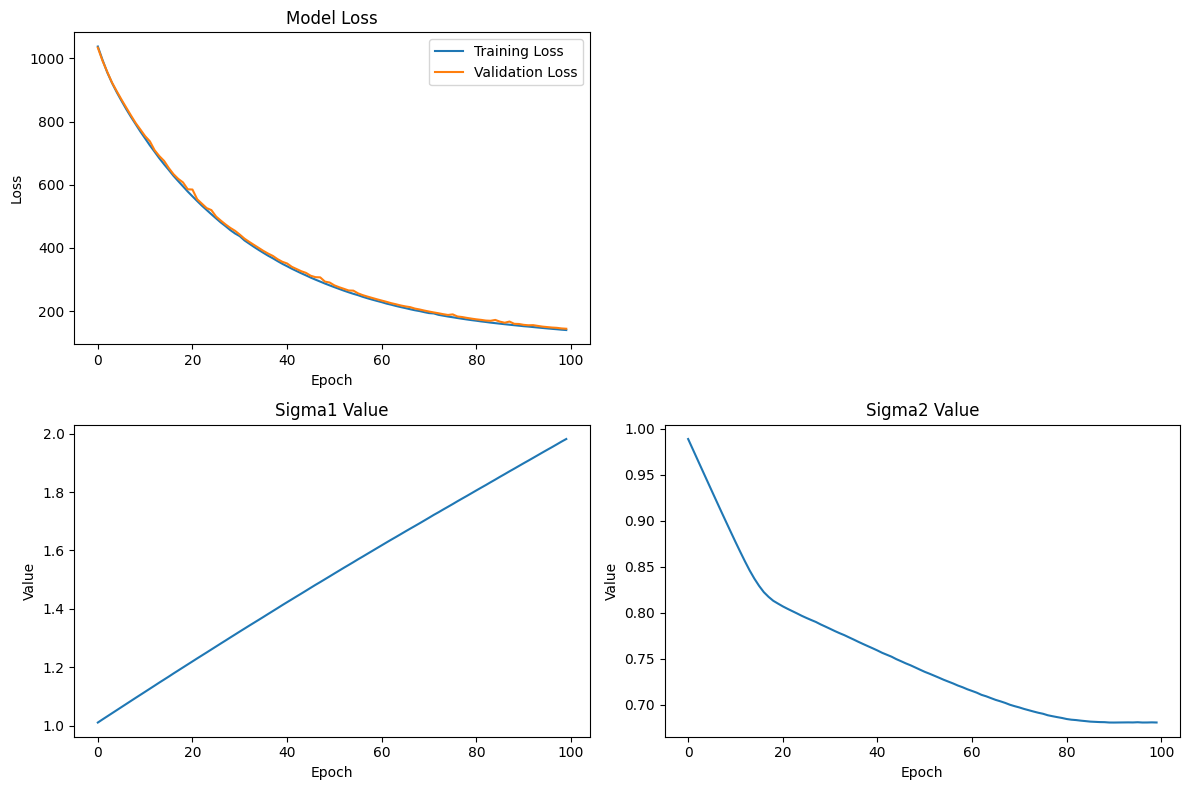

In [12]:
def monitor_sigma_values_and_loss(history):
    """
    Monitor the values of sigma1 and sigma2 during training.
    
    Args:
        history: Training history dictionary
    """
    # Get the values of sigma1 and sigma2
    sigma1_values = history['sigma1']
    sigma2_values = history['sigma2']
    
    print(f"Final sigma1 value: {sigma1_values[-1]}")
    print(f"Final sigma2 value: {sigma2_values[-1]}")
    
    # Plot the loss history
    plt.figure(figsize=(12, 8))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # # Plot MAE
    # plt.subplot(2, 2, 2)
    # plt.plot(history['train_mae'], label='Training MAE')
    # plt.plot(history['val_mae'], label='Validation MAE')
    # plt.title('Model MAE')
    # plt.xlabel('Epoch')
    # plt.ylabel('MAE')
    # plt.legend()

    # # Plot NMSE
    # plt.subplot(2, 2, 3)
    # plt.plot(history['train_nmse'], label='Training NMSE')
    # plt.plot(history['val_nmse'], label='Validation NMSE')
    # plt.title('Model NMSE')
    # plt.xlabel('Epoch')
    # plt.ylabel('NMSE')
    # plt.legend()

    # # Plot SNR
    # plt.subplot(2, 2, 4)
    # plt.plot(history['train_snr'], label='Training SNR')
    # plt.plot(history['val_snr'], label='Validation SNR')
    # plt.title('Model SNR')
    # plt.xlabel('Epoch')
    # plt.ylabel('SNR')
    # plt.legend()
    
    # # Plot PCC
    # plt.subplot(2, 2, 5)
    # plt.plot(history['train_pcc'], label='Training PCC')
    # plt.plot(history['val_pcc'], label='Validation PCC')
    # plt.title('Model PCC')
    # plt.xlabel('Epoch')
    # plt.ylabel('PCC')
    # plt.legend()
    
    # Plot sigma values
    plt.subplot(2, 2, 3)
    plt.plot(sigma1_values, label='Sigma1')
    plt.title('Sigma1 Value')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    
    plt.subplot(2, 2, 4)
    plt.plot(sigma2_values, label='Sigma2')
    plt.title('Sigma2 Value')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    
    plt.tight_layout()
    
    # Save figure to wandb
    if wandb.run is not None:
        wandb.log({"training_history": wandb.Image(plt)})
    
    plt.show()

monitor_sigma_values_and_loss(history)

In [13]:
# def visualize_results(model, val_dataset, device, subject_idx=0, channel_idx=0):
#     """
#     Visualize the results of the model on a validation sample.
    
#     Args:
#         model: Trained ESTformer model
#         val_dataset: Validation dataset
#         device: Device to run inference on
#         subject_idx: Index of the subject to visualize
#         channel_idx: Index of the channel to visualize
#     """
#     # Set model to eval mode
#     model.eval()
    
#     # Get a validation sample
#     sample = val_dataset[subject_idx]
    
#     # Convert to tensors and add batch dimension
#     lo_res = torch.tensor(sample['lo_res'], dtype=torch.float32).unsqueeze(0).to(device)
#     hi_res = torch.tensor(sample['hi_res'], dtype=torch.float32)
    
#     # Get predictions
#     with torch.no_grad():
#         pred = model(lo_res).cpu().numpy()[0]
    
#     # Convert back to numpy for visualization
#     lo_res = lo_res.cpu().numpy()[0]
#     hi_res = hi_res.numpy()
    
#     # Plot the results
#     plt.figure(figsize=(12, 8))
    
#     # Plot low-res input
#     plt.subplot(3, 1, 1)
#     plt.plot(lo_res[channel_idx])
#     plt.title(f'Low-Res (Downsampled) Input (Channel {channel_idx})')
    
#     # Plot high-res ground truth
#     plt.subplot(3, 1, 2)
#     plt.plot(hi_res[channel_idx])
#     plt.title(f'High-Res (Ground Truth) (Channel {channel_idx})')
    
#     # Plot prediction
#     plt.subplot(3, 1, 3)
#     plt.plot(pred[channel_idx])
#     plt.title(f'Super-Res (Prediction) (Channel {channel_idx})')
    
#     plt.tight_layout()
    
#     # Save figure to wandb
#     if wandb.run is not None:
#         wandb.log({"prediction_visualization": wandb.Image(plt)})
    
#     plt.show()

# visualize_results(model, val_loader.dataset, device)